In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (16,9)

#### Load the Data

In [2]:
df = pd.read_csv('_RES/TG_STAID002759.txt', sep=',' , skiprows = 19)

In [3]:
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
52772,111448,20200626,226,0
52773,111448,20200627,250,0
52774,111448,20200628,224,0
52775,111448,20200629,196,0


In [4]:
df.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [5]:
df.rename(columns = {' SOUID':'souid', '    DATE':'date', '   TG':'tg', ' Q_TG':'qtg'}, inplace=True)

In [6]:
df['DateTime'] = pd.to_datetime(df['date'].astype(str), format = '%Y%m%d')

In [7]:
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['week'] = df['DateTime'].dt.week
df['day'] = df['DateTime'].dt.day

In [8]:
df.drop('date', axis=1, inplace=True)

In [9]:
df.set_index('DateTime', inplace=True)

In [10]:
df['tg'] = df['tg'] * 0.1

In [11]:
df.head()

,souid,tg,qtg,year,month,week,day
DateTime,,,,,,,
1876-01-01,127488,2.2,0,1876,1,52,1
1876-01-02,127488,2.5,0,1876,1,52,2
1876-01-03,127488,0.3,0,1876,1,1,3
1876-01-04,127488,-5.8,0,1876,1,1,4
1876-01-05,127488,-9.8,0,1876,1,1,5


#### Check for missing values

In [12]:
df[df['qtg'] == 9]

,souid,tg,qtg,year,month,week,day
DateTime,,,,,,,
1945-04-25,127488,-999.9,9,1945,4,17,25
1945-04-26,127488,-999.9,9,1945,4,17,26
1945-04-27,127488,-999.9,9,1945,4,17,27
1945-04-28,127488,-999.9,9,1945,4,17,28
1945-04-29,127488,-999.9,9,1945,4,17,29
...,...,...,...,...,...,...,...
1945-11-01,127488,-999.9,9,1945,11,44,1
1945-11-02,127488,-999.9,9,1945,11,44,2
1945-11-03,127488,-999.9,9,1945,11,44,3


In [13]:
df['1944-04-25':'1944-11-05']['tg']

DateTime
1944-04-25    9.2
1944-04-26    9.2
1944-04-27    8.8
1944-04-28    8.6
1944-04-29    6.8
             ... 
1944-11-01    6.0
1944-11-02    5.4
1944-11-03    5.5
1944-11-04    7.2
1944-11-05    9.7
Name: tg, Length: 195, dtype: float64

In [14]:
df['1946-04-25':'1946-11-05']['tg']

DateTime
1946-04-25    13.8
1946-04-26    17.6
1946-04-27    15.8
1946-04-28    13.7
1946-04-29    13.4
              ... 
1946-11-01     4.8
1946-11-02     5.8
1946-11-03     7.0
1946-11-04     7.0
1946-11-05     5.8
Name: tg, Length: 195, dtype: float64

In [15]:
pd.Series((df['1946-04-25':'1946-11-05']['tg'].values + df['1944-04-25':'1944-11-05']['tg'].values)*0.5)

0      11.50
1      13.40
2      12.30
3      11.15
4      10.10
       ...  
190     5.40
191     5.60
192     6.25
193     7.10
194     7.75
Length: 195, dtype: float64

In [16]:
s_1945_new = pd.Series((df['1946-04-25':'1946-11-05']['tg'].values + df['1944-04-25':'1944-11-05']['tg'].values)*0.5)

In [17]:
s_1945_new.values.mean()

15.04897435897436

In [18]:
df.replace(df['1945-04-25':'1945-11-05']['tg'].values, s_1945_new.values.mean(), inplace=True)

In [19]:
df['1945-04-25':'1945-11-05']['tg']

DateTime
1945-04-25    15.048974
1945-04-26    15.048974
1945-04-27    15.048974
1945-04-28    15.048974
1945-04-29    15.048974
                ...    
1945-11-01    15.048974
1945-11-02    15.048974
1945-11-03    15.048974
1945-11-04    15.048974
1945-11-05    15.048974
Name: tg, Length: 195, dtype: float64

In [20]:
df[df['qtg'] == 9]

,souid,tg,qtg,year,month,week,day
DateTime,,,,,,,
1945-04-25,127488,15.048974,9,1945,4,17,25
1945-04-26,127488,15.048974,9,1945,4,17,26
1945-04-27,127488,15.048974,9,1945,4,17,27
1945-04-28,127488,15.048974,9,1945,4,17,28
1945-04-29,127488,15.048974,9,1945,4,17,29
...,...,...,...,...,...,...,...
1945-11-01,127488,15.048974,9,1945,11,44,1
1945-11-02,127488,15.048974,9,1945,11,44,2
1945-11-03,127488,15.048974,9,1945,11,44,3


In [21]:
df['souid'].unique()

array([127488, 128124, 111448])

In [22]:
df.drop('souid', axis=1, inplace=True)

In [23]:
df

,tg,qtg,year,month,week,day
DateTime,,,,,,
1876-01-01,2.2,0,1876,1,52,1
1876-01-02,2.5,0,1876,1,52,2
1876-01-03,0.3,0,1876,1,1,3
1876-01-04,-5.8,0,1876,1,1,4
1876-01-05,-9.8,0,1876,1,1,5
...,...,...,...,...,...,...
2020-06-26,22.6,0,2020,6,26,26
2020-06-27,25.0,0,2020,6,26,27
2020-06-28,22.4,0,2020,6,26,28


Last 365 days

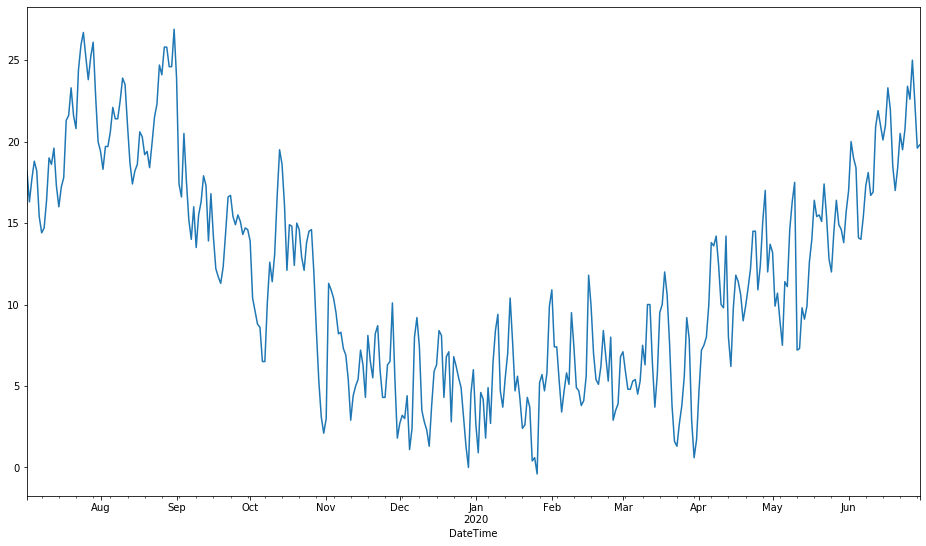

In [24]:
df.tail(365)['tg'].plot()

In [25]:
df.groupby(['month']).mean()

,tg,qtg,year,week,day
month,,,,,
1,-0.015239,0.000222,1948.000000,4.133037,16.000000
2,0.942725,0.000000,1948.011719,6.949707,14.627441
3,4.170612,0.000000,1948.000000,11.180868,16.000000
4,8.871976,0.012414,1948.000000,15.538391,15.500000
5,13.953085,0.062069,1948.000000,19.895884,16.000000
6,17.291487,0.062069,1948.000000,24.252414,15.500000
7,18.981971,0.062500,1947.500000,28.607303,16.000000
8,18.231276,0.062500,1947.500000,33.035842,16.000000
9,14.481937,0.062500,1947.500000,37.392361,15.500000


In [26]:
df.resample('M').mean()

,tg,qtg,year,month,week,day
DateTime,,,,,,
1876-01-31,-2.070968,0.0,1876.0,1.0,5.774194,16.0
1876-02-29,2.389655,0.0,1876.0,2.0,6.724138,15.0
1876-03-31,4.964516,0.0,1876.0,3.0,11.000000,16.0
1876-04-30,9.833333,0.0,1876.0,4.0,15.333333,15.5
1876-05-31,10.270968,0.0,1876.0,5.0,19.741935,16.0
...,...,...,...,...,...,...
2020-02-29,6.241379,0.0,2020.0,2.0,7.275862,15.0
2020-03-31,5.919355,0.0,2020.0,3.0,11.580645,16.0
2020-04-30,11.180000,0.0,2020.0,4.0,15.933333,15.5


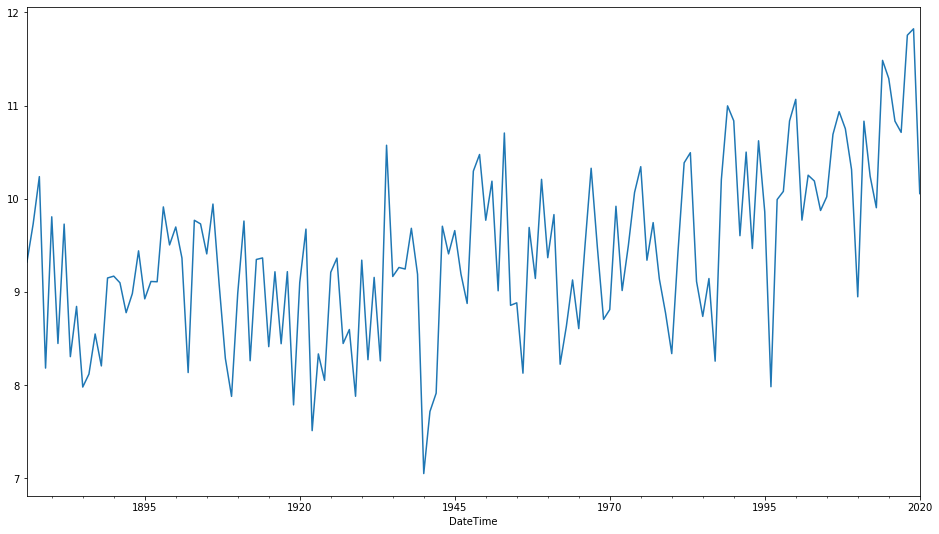

In [27]:
df.resample('y').mean()['tg'].plot()

#### Remove The Trend

In [28]:
df['temp_diff'] = df['tg'].diff()

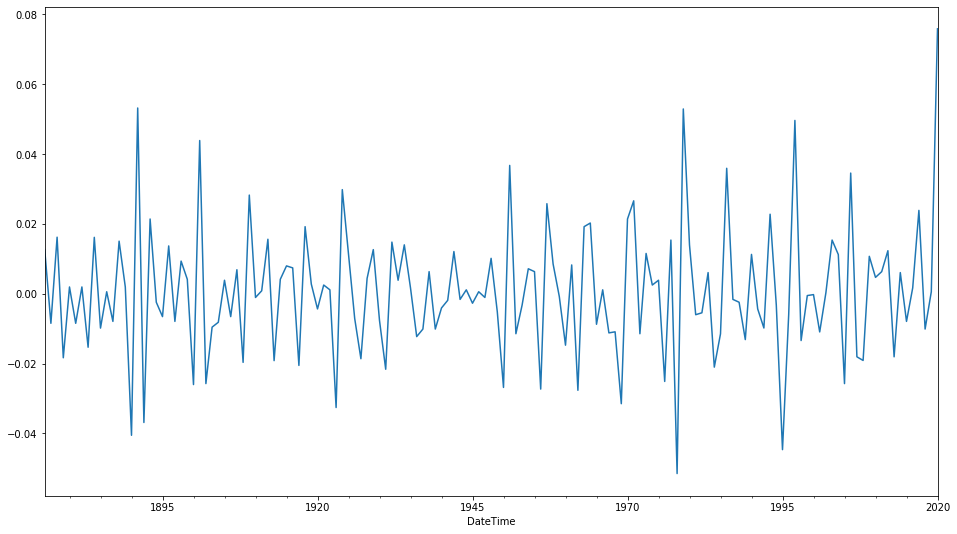

In [29]:
df.resample('y').mean()['temp_diff'].plot()

In [30]:
df['temp_diff'].mean()

0.0003334849173866921

#### Second Order Differencing

In [31]:
df['temp_diff_second'] = df['temp_diff'].diff()

In [32]:
df.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second
DateTime,,,,,,,,
1876-01-01,2.2,0,1876,1,52,1,NaN,NaN
1876-01-02,2.5,0,1876,1,52,2,0.3,NaN
1876-01-03,0.3,0,1876,1,1,3,-2.2,-2.5
1876-01-04,-5.8,0,1876,1,1,4,-6.1,-3.9
1876-01-05,-9.8,0,1876,1,1,5,-4.0,2.1


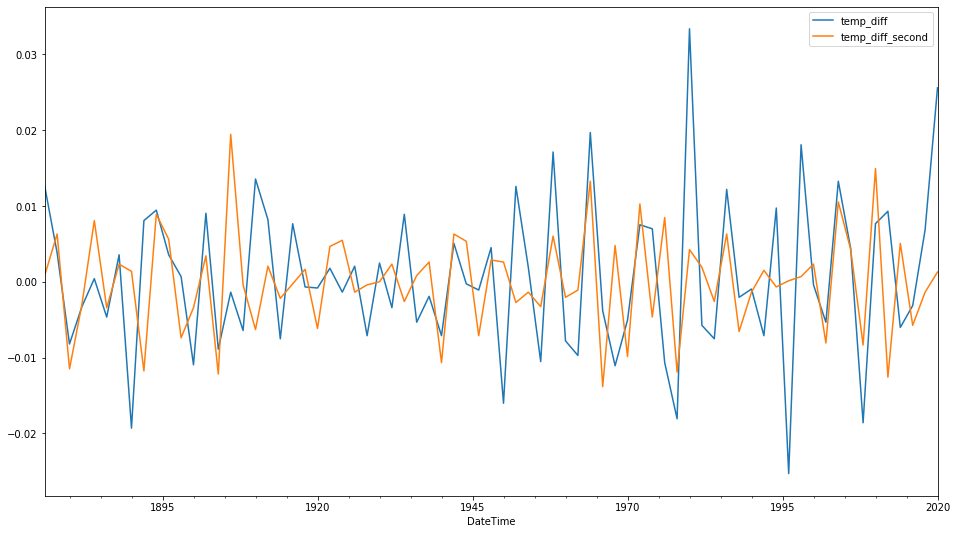

In [33]:
df.resample('2y')['temp_diff'].mean().plot()
df.resample('2y')['temp_diff_second'].mean().plot()

plt.legend()

Calculate percentage change

In [34]:
df['pct_change'] = df['tg'].pct_change()

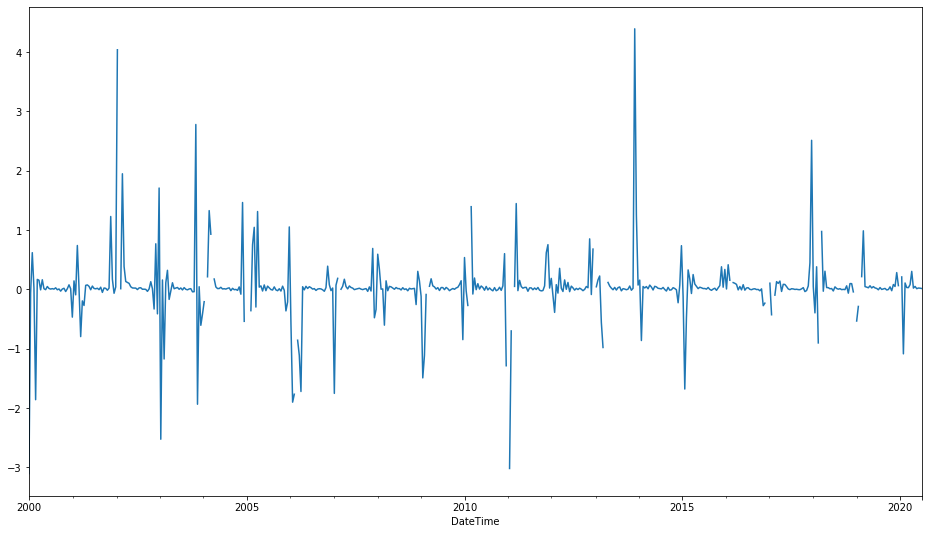

In [35]:
df['2000':'2020']['pct_change'].resample('2w').mean().plot()

In [36]:
# df['pct_change'].replace(['inf', '-inf'], '0', inplace=True)

In [37]:
df['2019']['pct_change'].describe()

count    365.000000
mean            inf
std             NaN
min       -8.000000
25%       -0.136842
50%        0.000000
75%        0.142857
max             inf
Name: pct_change, dtype: float64

In [38]:
df[df['pct_change']==np.inf]

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change
DateTime,,,,,,,,,
1876-11-14,5.6,0,1876,11,46,14,5.6,1.7,inf
1883-03-03,0.9,0,1883,3,9,3,0.9,3.1,inf
1883-12-11,0.2,0,1883,12,50,11,0.2,1.5,inf
1887-02-08,0.4,0,1887,2,6,8,0.4,4.0,inf
1888-03-23,0.1,0,1888,3,12,23,0.1,-0.4,inf
...,...,...,...,...,...,...,...,...,...
2013-03-18,0.3,0,2013,3,12,18,0.3,-1.2,inf
2013-04-03,0.6,0,2013,4,14,3,0.6,0.7,inf
2016-02-18,2.7,0,2016,2,7,18,2.7,3.1,inf


In [39]:
df['pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [40]:
df['pct_change'].fillna(0)

DateTime
1876-01-01     0.000000
1876-01-02     0.136364
1876-01-03    -0.880000
1876-01-04   -20.333333
1876-01-05     0.689655
                ...    
2020-06-26    -0.034188
2020-06-27     0.106195
2020-06-28    -0.104000
2020-06-29    -0.125000
2020-06-30     0.010204
Name: pct_change, Length: 52777, dtype: float64

In [41]:
df['2019']['pct_change'].describe()

count    363.000000
mean       0.033229
std        1.012547
min       -8.000000
25%       -0.138844
50%        0.000000
75%        0.139920
max       13.666667
Name: pct_change, dtype: float64

In [42]:
# df['pct_change'] = df.groupby('day')['pct_change'].transform('mean')

In [43]:
# df['pct_change']

In [44]:
# df['2019':'2020']['pct_change'].plot()

#### Remove the season

In [45]:
df['monthly_means'] = df.groupby('month')['temp_diff'].transform('mean')
df['weekly_means'] = df.groupby('week')['temp_diff'].transform('mean')
df.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means
DateTime,,,,,,,,,,,
1876-01-01,2.2,0,1876,1,52,1,NaN,NaN,NaN,-0.005496,-0.018335
1876-01-02,2.5,0,1876,1,52,2,0.3,NaN,0.136364,-0.005496,-0.018335
1876-01-03,0.3,0,1876,1,1,3,-2.2,-2.5,-0.880000,-0.005496,-0.092315
1876-01-04,-5.8,0,1876,1,1,4,-6.1,-3.9,-20.333333,-0.005496,-0.092315
1876-01-05,-9.8,0,1876,1,1,5,-4.0,2.1,0.689655,-0.005496,-0.092315


In [46]:
df['deseasonalized'] = df['temp_diff'] - df['monthly_means']

In [47]:
df['deseasonalized'].mean()

1.0032839093894057e-16

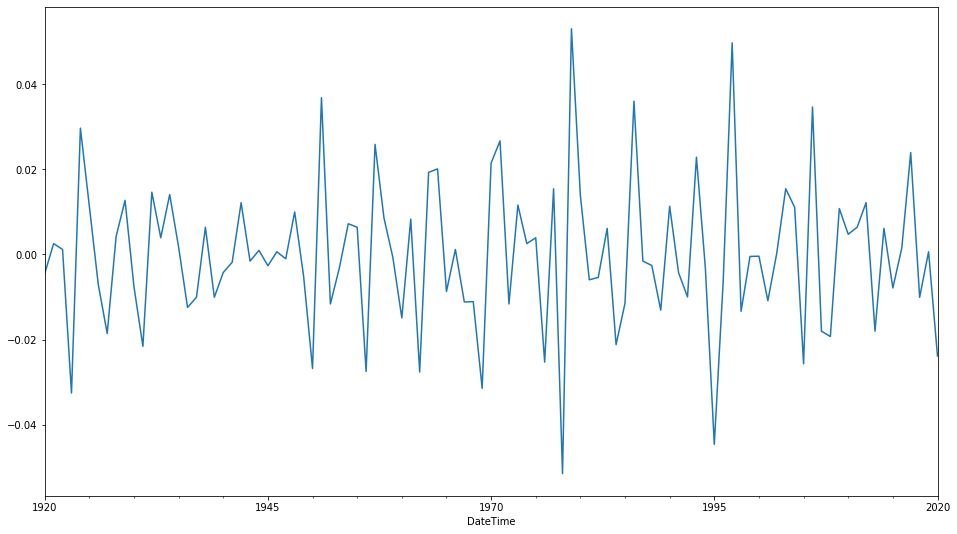

In [48]:
df['1920':'2020'].resample('y').mean()['deseasonalized'].plot()

#### Split into train and test data sets

In [49]:
y_train = df[:'2019'].copy()
y_test = df['2020'].copy()

#### Define function that plots prediction

In [50]:
def make_plot(y_train, y_test, columns):
    """
    This function plots predictions and compares them to the actual test data
    
    Parameters:
    y_train = df of training data
    y_test = df of test data
    columns = List of strings
    """
    
    y_train.resample('w').mean()['2010':'2019']['tg'].plot(label = 'Training Data')
    y_test.resample('w').mean()['tg'].plot(label='Test data')

    for column in columns:
        y_test.resample('w').mean()[column].plot(label=column)
    
    plt.title = 'Temperature prediction for Berlin Tempelhof'
    plt.xlabel = 'time'
    plt.ylabel = 'temperature'
    plt.legend()

#### Mean of time series

In [51]:
y_train['tg'].mean()

9.394023196121369

#### Add the mean value of temperature as prediction for y_test

In [52]:
y_test['y_pred_mean'] = y_train['tg'].mean()
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean
DateTime,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023


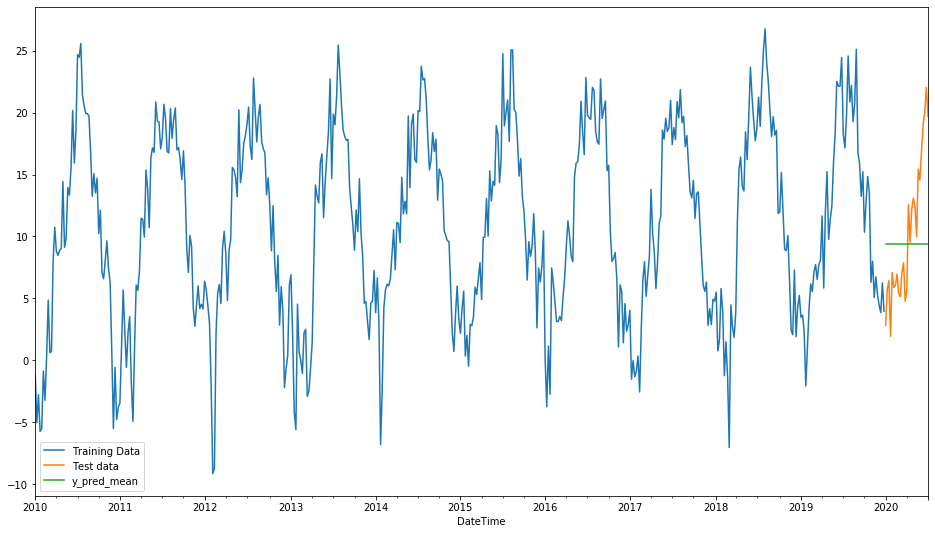

In [53]:
make_plot(y_train, y_test, ['y_pred_mean'])

This doesn't look like anything to me

#### Plot mean of detrended df

In [54]:
y_test['y_pred_pct_change_mean'] = y_train['2000':'2019']['pct_change'].mean()
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean
DateTime,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,0.013452
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,0.013452
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,0.013452
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,0.013452
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,0.013452


In [55]:
y_test['y_pred_pct_change_mean'] += 1
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean
DateTime,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,1.013452
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,1.013452
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,1.013452
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,1.013452
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,1.013452


Calculate the culmulative product of the mean percentage change

In [56]:
y_test['y_pred_pct_change_mean'] = np.cumprod(y_test['y_pred_pct_change_mean'])
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean
DateTime,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,1.013452
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,1.027085
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,1.040902
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,1.054905
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,1.069095


Define the intercept aka last starting point

In [57]:
intercept = y_train['tg'][-1]

In [58]:
y_test['y_pred_pct_change_mean'] *= intercept
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean
DateTime,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573


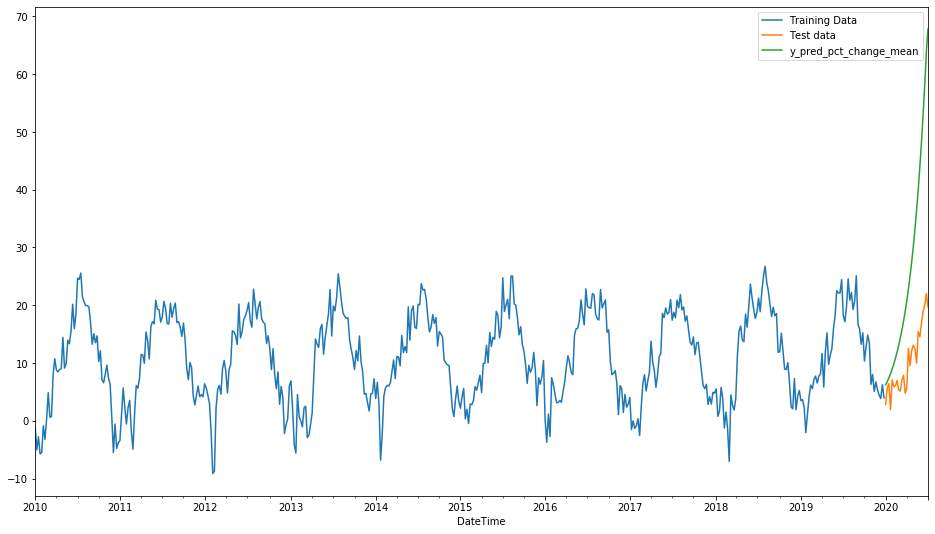

In [59]:
make_plot(y_train, y_test, ['y_pred_pct_change_mean'])

Oh, well. Let's move on ...

#### Let's see if we can take the seasonal patterns into account

In [60]:
y_train['weekly_means'].unique()

array([-0.01833499, -0.09231527, -0.03369458,  0.0546798 , -0.00226601,
        0.00059113,  0.06147783,  0.09034483,  0.13024631,  0.0520197 ,
        0.14472906,  0.07714286,  0.22561576,  0.19881773,  0.04817734,
        0.1853202 ,  0.22935961,  0.16625515,  0.13763547,  0.25280788,
        0.07280788,  0.13182266,  0.22640394, -0.04009852,  0.01655172,
        0.111133  ,  0.16128079,  0.00425743,  0.01547619,  0.03501984,
        0.06795635, -0.07390873, -0.05625   , -0.06845238, -0.16904762,
       -0.09672619, -0.10515873, -0.17668651, -0.15277778, -0.17103175,
       -0.18293651, -0.16894841, -0.11021825, -0.20565476, -0.10892857,
       -0.26254859, -0.13630952, -0.07718254, -0.16299603, -0.06825397,
       -0.00446429, -0.15178571, -0.00914286])

In [61]:
len(y_test)

182

In [62]:
y_train['weekly_means'][:182]

DateTime
1876-01-01   -0.018335
1876-01-02   -0.018335
1876-01-03   -0.092315
1876-01-04   -0.092315
1876-01-05   -0.092315
                ...   
1876-06-26    0.161281
1876-06-27    0.161281
1876-06-28    0.161281
1876-06-29    0.161281
1876-06-30    0.161281
Name: weekly_means, Length: 182, dtype: float64

In [63]:
y_test['y_pred_weekly_pct_mean'] = y_train['weekly_means'][:182].values

In [64]:
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean,y_pred_weekly_pct_mean
DateTime,,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714,-0.018335
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513,-0.018335
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413,-0.092315
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428,-0.092315
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573,-0.092315


In [65]:
y_test['y_pred_weekly_pct_mean'] += 1
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean,y_pred_weekly_pct_mean
DateTime,,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714,0.981665
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513,0.981665
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413,0.907685
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428,0.907685
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573,0.907685


In [66]:
y_test['y_pred_weekly_pct_mean'] = np.cumprod(y_test['y_pred_weekly_pct_mean'])
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean,y_pred_weekly_pct_mean
DateTime,,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714,0.981665
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513,0.963666
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413,0.874705
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428,0.793956
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573,0.720662


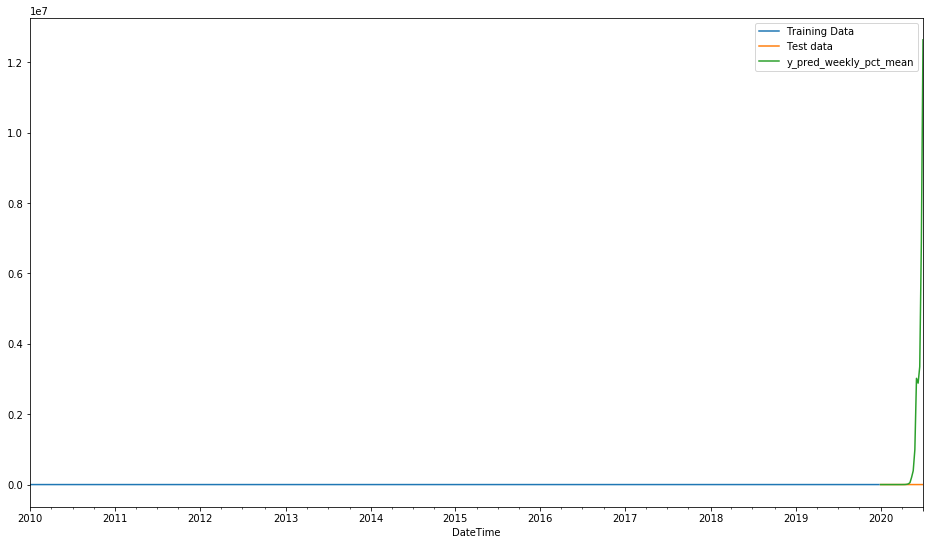

In [67]:
make_plot(y_train, y_test, ['y_pred_weekly_pct_mean'])

#### Persistance Forecast

In [68]:
y_test['y_pred_persistence'] = y_test['tg'].shift()

In [69]:
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean,y_pred_weekly_pct_mean,y_pred_persistence
DateTime,,,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714,0.981665,NaN
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513,0.963666,2.7
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413,0.874705,0.9
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428,0.793956,4.6
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573,0.720662,4.2


In [70]:
y_test.loc['2020-01-01','y_pred_persistence'] = intercept.copy()

In [71]:
y_test.head()

,tg,qtg,year,month,week,day,temp_diff,temp_diff_second,pct_change,monthly_means,weekly_means,deseasonalized,y_pred_mean,y_pred_pct_change_mean,y_pred_weekly_pct_mean,y_pred_persistence
DateTime,,,,,,,,,,,,,,,,
2020-01-01,2.7,0,2020,1,1,1,-3.3,-4.8,-0.550000,-0.005496,-0.092315,-3.294504,9.394023,6.080714,0.981665,6.0
2020-01-02,0.9,0,2020,1,1,2,-1.8,1.5,-0.666667,-0.005496,-0.092315,-1.794504,9.394023,6.162513,0.963666,2.7
2020-01-03,4.6,0,2020,1,1,3,3.7,5.5,4.111111,-0.005496,-0.092315,3.705496,9.394023,6.245413,0.874705,0.9
2020-01-04,4.2,0,2020,1,1,4,-0.4,-4.1,-0.086957,-0.005496,-0.092315,-0.394504,9.394023,6.329428,0.793956,4.6
2020-01-05,1.8,0,2020,1,1,5,-2.4,-2.0,-0.571429,-0.005496,-0.092315,-2.394504,9.394023,6.414573,0.720662,4.2


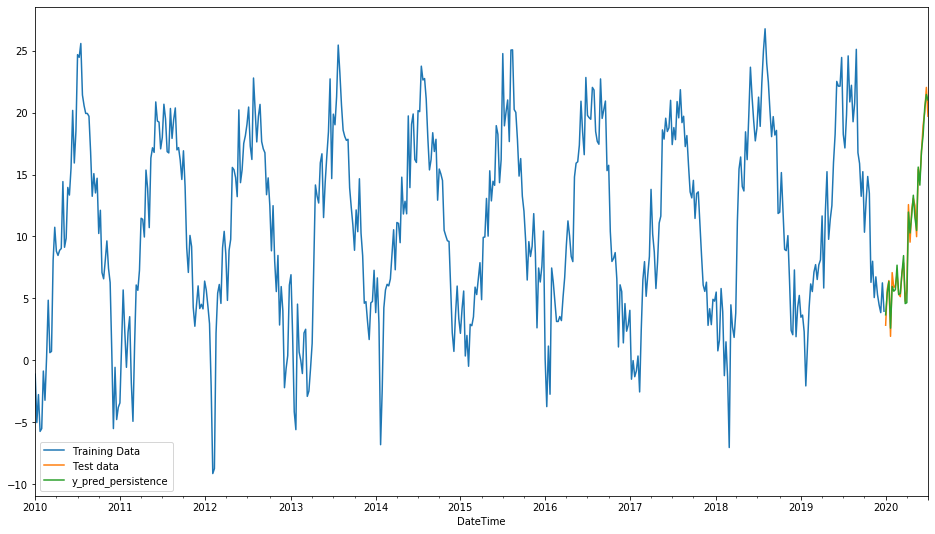

In [72]:
make_plot(y_train, y_test, ['y_pred_persistence'])

#### Plot all of them together

In [73]:
predictions = ['y_pred_mean', 'y_pred_pct_change_mean', 'y_pred_persistence']

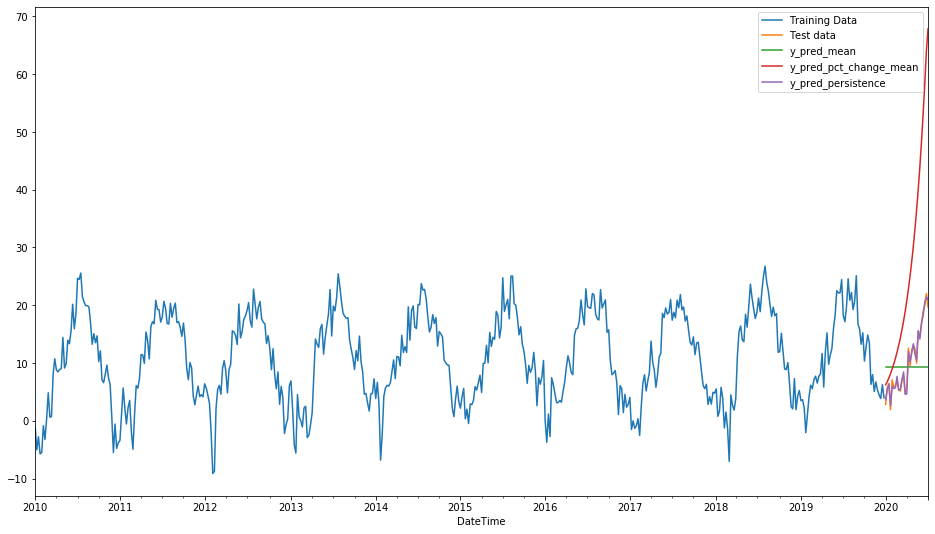

In [74]:
make_plot(y_train, y_test, predictions)

#### Compare all of them together

In [75]:
for prediction in predictions:
    print(f'{prediction} : {mean_absolute_error(y_test["tg"], y_test[prediction])}')

y_pred_mean : 4.833582162679985
y_pred_pct_change_mean : 15.84586650266342
y_pred_persistence : 1.875824175824176


In [78]:
seasonal = seasonal_decompose(df['2010':'2020']['tg'])

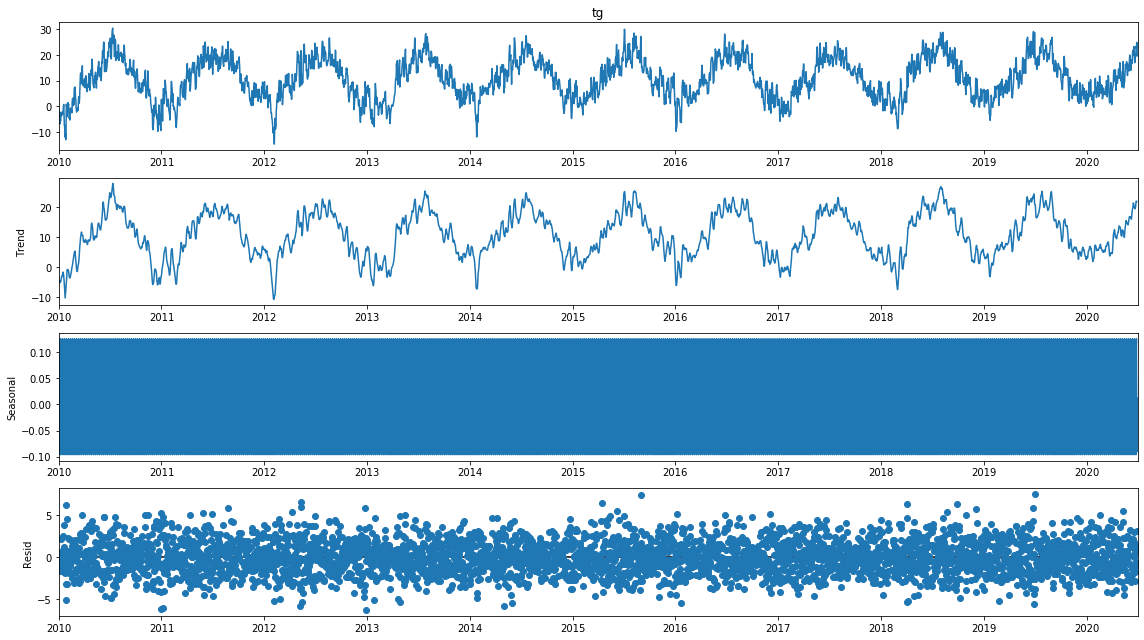

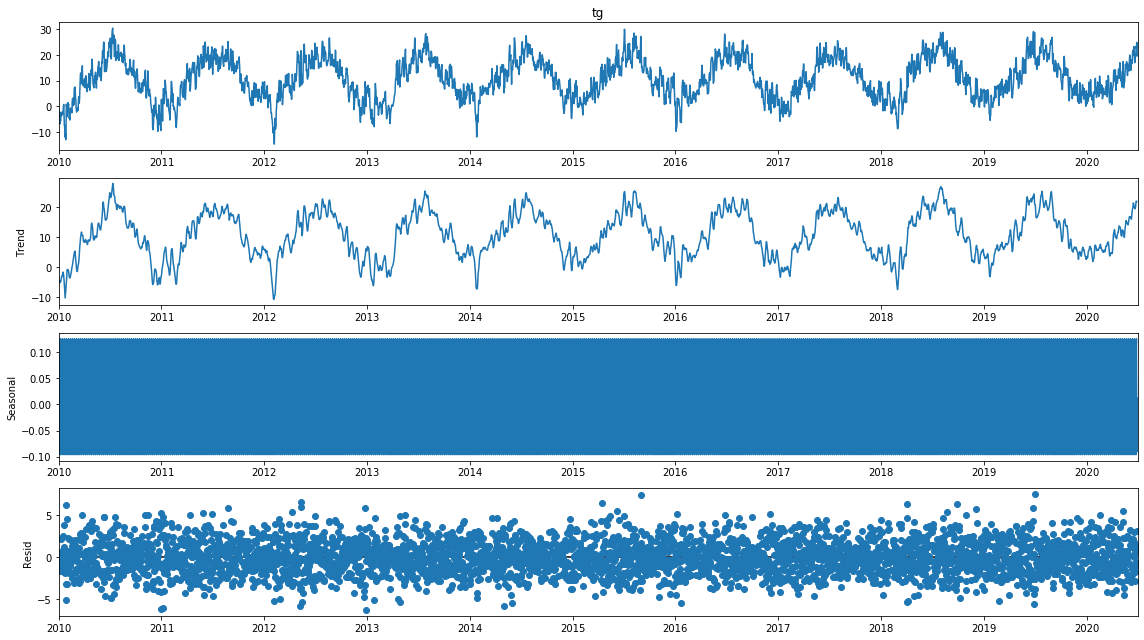

In [79]:
seasonal.plot()